In [ ]:
from google.colab import drive
import os

import numpy as np
from PIL import Image
from keras.utils import to_categorical

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/good_gTruth/Binary_files')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def selected_tiles(l, X, size):
  i,k,m=0,0,0
  X_test = np.zeros((50, 224, 224, size), dtype = np.float32)
  X_train = np.zeros((200, 224, 224, size), dtype = np.float32)
  while i < 250:
    if i in l:
      X_test[k] = X[i]
      k+=1
      #print('k:', k)
    if i not in l:
      X_train[m] = X[i]
      m+=1
      #print('m:', m)
    #print(i)
    i+=1
  
  return X_test, X_train

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import backend as K


def unet_model(n_classes=6, im_sz=224, n_channels=9, n_filters_start=32, growth_factor=2, upconv=True,
               class_weights=[1.3453, 1.0000, 1.1585, 0.4894, 0.5044, 0.01]):
    droprate=0.25
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    '''def weighted_binary_crossentropy(y_true, y_pred):
        class_loglosses = K.mean(K.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
        return K.sum(class_loglosses * K.constant(class_weights))'''

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def initialize_elements():
  from PIL import Image
  import os
  import numpy as np 
  import math 
  import cmath
  original = ['T11.bin', 'T12_imag.bin', 'T12_real.bin', 'T13_imag.bin', 'T13_real.bin', 'T22.bin', 'T23_imag.bin', 'T23_real.bin', 'T33.bin']
  #original = ['Seven_Pv.bin', 'Seven_Ps.bin', 'Seven_Pod.bin', 'Seven_Pmd.bin', 'Seven_Ph.bin', 'Seven_Pd.bin', 'Seven_Pcd.bin']
  #original = ['Singh4_G4U2_Vol.bin', 'Singh4_G4U2_Odd.bin', 'Singh4_G4U2_Hlx.bin', 'Singh4_G4U2_Dbl.bin']
  #original = ['TSVM_alpha_s1.bin', 'TSVM_phi_s1.bin', 'TSVM_psi1.bin', 'TSVM_tau_m1.bin']
  #original = ['TSVM_alpha_s1.bin', 'TSVM_alpha_s2.bin', 'TSVM_phi_s1.bin', 'TSVM_phi_s2.bin', 'TSVM_psi1.bin', 'TSVM_psi2.bin', 'TSVM_tau_m1.bin', 'TSVM_tau_m2.bin']
  #original = ['TSVM_alpha_s1.jp2', 'TSVM_phi_s1.jp2', 'TSVM_psi1.jp2', 'TSVM_tau_m1.jp2']
  #original = ['T11.jp2', 'T12_imag.jp2', 'T12_real.jp2', 'T13_imag.jp2', 'T13_real.jp2', 'T22.jp2', 'T23_imag.jp2', 'T23_real.jp2', 'T33.jp2']

  print(original) #['Seven_Pv.jp2', 'Seven_Ps.jp2', 'Seven_Pod.jp2', 'Seven_Pmd.jp2', 'Seven_Ph.jp2', 'Seven_Pd.jp2', 'Seven_Pcd.jp2']
  X_7B = np.zeros((1554,1228, 9), dtype = np.float32)
  i=0

  
  #stacking the 7/4/9 layers
  for band in original:
    T = np.fromfile(band,  dtype=np.float32)
    T= T.reshape(1554,1228)
    X_7B[:,:,i]=T
    i=i+1
  
  '''
  for band in original:
    path = os.path.join('/content/gdrive/My Drive/good_gTruth/9_bands/', band)
    B = Image.open(path)
    X_7B[:,:,i]=B
    i=i+1
  '''
  
  print(X_7B.size) #13358184
  print(X_7B[0][0].size) #7

  #Taking the masking as an input
  M_7B = np.zeros((1554,1228, 1), dtype = np.float32)
  path = os.path.join('/content/gdrive/My Drive/good_gTruth/', 'Label_1.png')
  B = Image.open(path)
  M_7B[:,:,0]=B

  import numpy as np
  import os
  from PIL import Image
  from keras.utils import to_categorical
  mask = np.zeros((1554,1228), dtype = np.float32)
  M_7B_one = np.zeros((1554,1228, 6), dtype = np.float32)
  path = os.path.join('/content/gdrive/My Drive/good_gTruth/', 'Label_1.png')
  B = Image.open(path)
  encoded = to_categorical(B)
  #print(encoded)
  M_7B_one[:,:,:]=encoded

  print(M_7B.size) #1908312
  print(M_7B[0][0].size) #1
  print(M_7B_one.size) #

  #Creating overlapping tiles 
  X = np.zeros((250, 224, 224, 9), dtype = np.float32)
  i=0
  pixel_row=0
  counter=1
  while pixel_row < 1329: 
      pixel_col=0
      while pixel_col < 1005:
          pic_part = X_7B[pixel_row:(pixel_row+224), pixel_col:(pixel_col+224),:]
          X[i] = pic_part
          i = i+1
          pixel_col=pixel_col+111
          counter = counter+1
      pixel_row=pixel_row+55

  print(X.shape) #(250, 224, 224, 10)

  #creating tiles for masking as well

  Y = np.zeros((250, 224, 224, 1), dtype = np.float32)
  Y_one = np.zeros((250, 224, 224, 6), dtype = np.float32)
  i=0
  pixel_row=0
  counter=1
  while pixel_row < 1329: 
      pixel_col=0
      while pixel_col < 1005:
          pic_part = M_7B[pixel_row:(pixel_row+224), pixel_col:(pixel_col+224),:]
          Y[i] = pic_part
          Y_one[i] = M_7B_one[pixel_row:(pixel_row+224), pixel_col:(pixel_col+224),:]
          i = i+1
          pixel_col=pixel_col+111
          counter = counter+1
      pixel_row=pixel_row+55

  print(Y.shape) #(250, 224, 224, 1)
  print(Y_one.shape) #


  #l = Rand(0,250,50)
  l = [247, 44, 230, 57, 85, 182, 199, 241, 27, 106, 123, 53, 117, 87, 213, 210, 162, 224, 45, 63, 205, 78, 14, 55, 59, 155, 172, 16, 74, 5, 22, 7, 86, 156, 103, 60, 109, 79, 101, 227, 186, 233, 215, 56, 72, 192, 94, 119, 112, 214]
  print(l)
  X_test, X_train = selected_tiles(l, X, 9)
  Y_test, Y_train = selected_tiles(l, Y_one, 6)
  Mask_test, Mask_train = selected_tiles(l, Y, 1)

  from sklearn.model_selection import train_test_split

  X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.20,train_size =0.80)  

  print(X_train.shape)
  print(X_val.shape)
  print(X_test.shape)

  #(160, 224, 224, 7)
  #(40, 224, 224, 7)
  #(50, 224, 224, 7)
  
  print(Y_train.shape)
  print(Y_val.shape)
  print(Y_test.shape)
  print(Mask_test.shape)

  #(160, 224, 224, 1)
  #(40, 224, 224, 1)
  #(50, 224, 224, 1)

  return X_train, X_val, X_test, Y_train, Y_val, Y_test, Mask_test

In [ ]:
X_train, X_val, X_test, Y_train, Y_val, Y_test, Mask_test = initialize_elements()

['T11.bin', 'T12_imag.bin', 'T12_real.bin', 'T13_imag.bin', 'T13_real.bin', 'T22.bin', 'T23_imag.bin', 'T23_real.bin', 'T33.bin']
17174808
9
1908312
1
11449872
(250, 224, 224, 9)
(250, 224, 224, 1)
(250, 224, 224, 6)
[247, 44, 230, 57, 85, 182, 199, 241, 27, 106, 123, 53, 117, 87, 213, 210, 162, 224, 45, 63, 205, 78, 14, 55, 59, 155, 172, 16, 74, 5, 22, 7, 86, 156, 103, 60, 109, 79, 101, 227, 186, 233, 215, 56, 72, 192, 94, 119, 112, 214]
(160, 224, 224, 9)
(40, 224, 224, 9)
(50, 224, 224, 9)
(160, 224, 224, 6)
(40, 224, 224, 6)
(50, 224, 224, 6)
(50, 224, 224, 1)


In [ ]:
model = unet_model(n_classes=6, im_sz=224, n_channels=9, n_filters_start=32, growth_factor=2, upconv=True,
               class_weights=[0.4894, 0.5044, 1.0000, 1.1585, 1.3453, 0.01])
model.fit(X_train, Y_train, batch_size=10, epochs=100, shuffle=True,
                  validation_data=(X_val, Y_val))

Epoch 1/100
16/16 [==============================] - 4s 166ms/step - loss: 1.6318 - accuracy: 0.3508 - val_loss: 1.4692 - val_accuracy: 0.3644
Epoch 2/100
16/16 [==============================] - 2s 131ms/step - loss: 1.1671 - accuracy: 0.6100 - val_loss: 1.3313 - val_accuracy: 0.6634
Epoch 3/100
16/16 [==============================] - 2s 131ms/step - loss: 0.9344 - accuracy: 0.6266 - val_loss: 1.4063 - val_accuracy: 0.4102
Epoch 4/100
16/16 [==============================] - 2s 132ms/step - loss: 0.9137 - accuracy: 0.6340 - val_loss: 1.1574 - val_accuracy: 0.7060
Epoch 5/100
16/16 [==============================] - 2s 131ms/step - loss: 0.8933 - accuracy: 0.6669 - val_loss: 1.0331 - val_accuracy: 0.7185
Epoch 6/100
16/16 [==============================] - 2s 130ms/step - loss: 0.8553 - accuracy: 0.7119 - val_loss: 1.1385 - val_accuracy: 0.6088
Epoch 7/100
16/16 [==============================] - 2s 131ms/step - loss: 0.7334 - accuracy: 0.7322 - val_loss: 1.2384 - val_accuracy: 0.4600

In [ ]:
loss, acc = model.evaluate(X_test, Y_test)

2/2 [==============================] - 1s 70ms/step - loss: 0.1574 - accuracy: 0.9504


In [ ]:
model.save('/content/gdrive/My Drive/good_gTruth/Models/model_t3_bin_nr01.h5')

In [ ]:
loss, acc = model.evaluate(X_test,  Y_test)
preds = model.predict(X_test)

import numpy as np
from PIL import Image

img = np.zeros((224,224,3),np.uint8)
Preds_max = np.zeros((50, 224, 224, 1), dtype = np.float32)
p=0

for one in preds:
  #print(one.shape)
  #print(one[0][0][0])
  for i in range(224):
    for j in range(224):
      if np.argmax(one[i][j]) == 1:  #Ocean
        img[i,j] = [0,0,255]
      elif np.argmax(one[i][j]) == 2:    #Settlement
        img[i,j] = [255,0,0]
      elif np.argmax(one[i][j]) == 3:    #Forest
        img[i,j] = [0, 255, 0]
      elif np.argmax(one[i][j]) == 4:    #Mangroves
        img[i,j] = [255,255,0]
      elif np.argmax(one[i][j]) == 5:    #Agriculture
        img[i,j] = [255,182,193]
      else:    #Undefined
        img[i,j] = [255,255,255]
      Preds_max[p][i][j] = np.argmax(one[i][j])
  name = '/content/gdrive/My Drive/good_gTruth/Test/jpeg/t3_bin/' + str(p) + '.png'
  xgb_image = Image.fromarray(img, 'RGB')
  xgb_image.save(name)
  p=p+1
  print(p)

print(Preds_max.shape)
print(Preds_max[0][0][0])

2/2 [==============================] - 0s 73ms/step - loss: 0.1574 - accuracy: 0.9504
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
(50, 224, 224, 1)
[2.]


In [ ]:
from tensorflow import keras
import tensorflow as tf

model = keras.models.load_model("/content/gdrive/My Drive/good_gTruth/Models/model_t3_bin_nr01.h5")

In [ ]:
preds = model.predict(X_test)

import numpy as np
from PIL import Image

Preds_max = np.zeros((50, 224, 224, 1), dtype = np.float32)
p=0

for one in preds:
  #print(one.shape)
  #print(one[0][0][0])
  for i in range(224):
    for j in range(224):
      Preds_max[p][i][j] = np.argmax(one[i][j])
  p=p+1
  print(p)

print(Preds_max.shape)
print(Preds_max[0][0][0])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
(50, 224, 224, 1)
[2.]


In [ ]:
preds = Preds_max.reshape(-1)
#y = Y_n.reshape(-1)
y= Mask_test.reshape(-1)
print(Mask_test.size)
print(Preds_max.size)

2508800
2508800


In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(preds, y, labels=[0,1,2,3,4,5]))

[[  5774   1338   2277    261    497    150]
 [  4938 716433   1690    729   2157    409]
 [  5284    481 787466   9725  13208   4607]
 [  2521    928   5012 460419   4105   1711]
 [  5923   7201  11198   1539 253496   5445]
 [  4394   2054  10448   3769  10560 160653]]


In [ ]:
C = confusion_matrix(preds, y)
#np.around(C.astype('float') / C.sum(axis=1)[:, np.newaxis], decimals=2)

print(np.around(C.astype('float') / C.sum(axis=1)[:, np.newaxis], decimals=3))

[[0.561 0.13  0.221 0.025 0.048 0.015]
 [0.007 0.986 0.002 0.001 0.003 0.001]
 [0.006 0.001 0.959 0.012 0.016 0.006]
 [0.005 0.002 0.011 0.97  0.009 0.004]
 [0.021 0.025 0.039 0.005 0.89  0.019]
 [0.023 0.011 0.054 0.02  0.055 0.837]]


In [ ]:
print(C[1:])
print(C[1:,1:])

[[  4938 716433   1690    729   2157    409]
 [  5284    481 787466   9725  13208   4607]
 [  2521    928   5012 460419   4105   1711]
 [  5923   7201  11198   1539 253496   5445]
 [  4394   2054  10448   3769  10560 160653]]
[[716433   1690    729   2157    409]
 [   481 787466   9725  13208   4607]
 [   928   5012 460419   4105   1711]
 [  7201  11198   1539 253496   5445]
 [  2054  10448   3769  10560 160653]]


In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy
    cm = np.around(cm[1:,1:].astype('float') / cm[1:,1:].sum(axis=1)[:, np.newaxis], decimals=3)

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


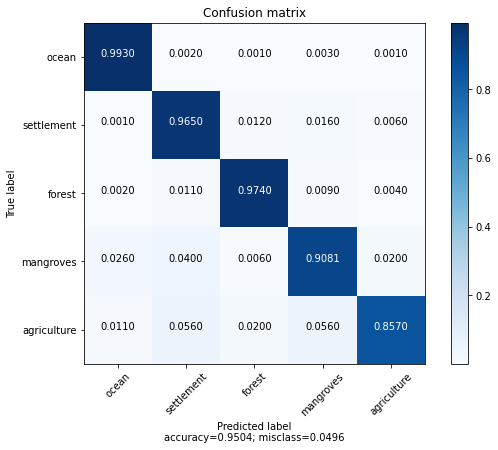

In [ ]:
labels = [0,1,2,3,4,5]
l = ['ocean','settlement','forest','mangroves','agriculture']
plot_confusion_matrix(C,l,title='Confusion matrix',cmap = None, normalize=True)